# 4 Assets - Commodities, ETFs & Forex Simulation

This notebook simulates the rebalancing algorithim with a variety of stocks, forex and commodity assets.

In [1]:
%run logs.ipynb
%run models.ipynb
%run import_data.ipynb
%run preprocessing.ipynb
%run visualizations.ipynb

### Read data from various sources
Here we prepare our data from various sources. We take 4 different assets from various sources and buying power represented in USD terms.

Asset prices were downloaded from Quandl and saved in this repo as CSV files. Most we are taking the open prices.

In [2]:
raw_asset_aud_usd = read_perth_daily_data(asset_name='AUD/USD')
raw_asset_gld_usd = read_perth_daily_data(asset_name='GOLD/USD')
raw_asset_spy = read_yahoo_finance_daily_data(asset_name='SPY')
raw_asset_eur_usd = read_ecb_daily_data(asset_name='EUR/USD')
raw_asset_wbtc_usd = read_crypto_dialy_data(asset_name='WBTC/USD')
raw_asset_eth_usd = read_crypto_dialy_data(asset_name='ETH/USD')
raw_asset_btc_usd = read_crypto_dialy_data(asset_name='BTC/USD')
raw_asset_dai_usd = read_crypto_dialy_data(asset_name='DAI/USD')
raw_asset_usdc_usd = read_crypto_dialy_data(asset_name='USDC/USD')
raw_asset_tusd_usd = read_crypto_dialy_data(asset_name='TUSD/USD')

multiple_assets_raw_df = get_df_for_multiple_assets(
    raw_asset_eur_usd, #EUR/USD
    raw_asset_gld_usd, #GOLD/USD
    raw_asset_wbtc_usd, #WBTC/USD
    raw_asset_eth_usd #ETH/USD
).sort_values(by='Date').reset_index(drop=True)

# To give average price of the year.
df_info = multiple_assets_raw_df.groupby(multiple_assets_raw_df['Date'].dt.year).agg(['mean', 'max', 'min'])
df_info.columns = ["_".join(x) for x in df_info.columns.ravel()]
df_info.columns = ["_".join(x.split("_")[-2: ]) for x in df_info.columns]

df_info.head(df_info.shape[0])

,EUR/USD_mean,EUR/USD_max,EUR/USD_min,GOLD/USD_mean,GOLD/USD_max,GOLD/USD_min,WBTC/USD_mean,WBTC/USD_max,WBTC/USD_min,ETH/USD_mean,ETH/USD_max,ETH/USD_min
Date,,,,,,,,,,,,
2019,1.117589,1.1488,1.0889,1399.330179,1543.71,1268.07,7696.205736,12510.267110,3395.978616,186.275761,336.753188,104.535299
2020,1.117218,1.1940,1.0707,1707.676189,2058.12,1480.38,9043.446226,12299.789807,4946.043031,229.365443,437.397840,110.605876


# Running the Simulation - 20 years of data

Here we try with data from 1990-2020 and keep 50% of the vault in GOLD and the remaining in Australian Dollar, Euro and SPY500 ETF. AUS and EUR will represent the fiat markets and SPY500 ETF will represent the stock market. Since usually gold is used as a hedge against the stock & forex markets, we keep a 50% ratio in gold.

We use the following parameters:

- Stop sell of 30%
- Stop loss of 30%
- 5% slippage for every rebalance
- Rebalance to happen once every 7 days
- 50% of the appreciated value from the appreciating asset, is sold off during every rebalance
- Starting with a buying power of 100 (so that it is easy to measure % increase)

And assets are distributed with the following ratios:

- Australian Dollar (25% starting buying power)
- Gold (25% starting buying power) 
- S&P 500 ETF (25% starting buying power)
- Euro (25% starting buying power)

### Results

At the end of the simulation, the vault has rebalanced itself around 90 times over the course of 20 years and is up by 309%.

Finished with 6 rebalances
Final buying power of the vault is 184



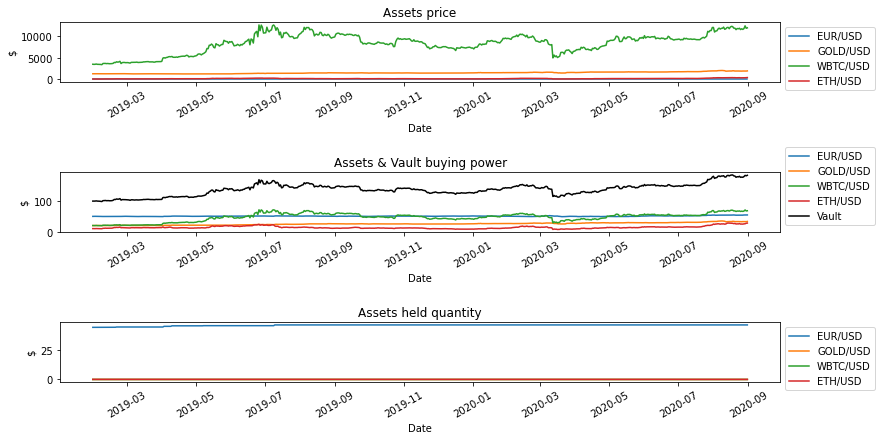

In [3]:
start_date = pd.Timestamp('today').floor('D') + pd.Timedelta(-20 * 365, unit='D') 
end_date = pd.Timestamp('today').floor('D') + pd.Timedelta(-0 * 365, unit='D')

multiple_assets_df = get_df_data_within_range(df=multiple_assets_raw_df, from_date=start_date, to_date=end_date)
multiple_assets_df_list = get_multiple_assets_df_list(multiple_assets_df)

simulation_logs, initial_vault, vault = simulate_multiple_assets_vault(
    multiple_assets_df_list,
    [0.5, 0.2, 0.2, 0.1],
    starting_buying_power=100,
    slippage=0.05,
    sell_apr_percentage=0.5,
    rebalance_interval_days=7,
    stop_sell=0.3,
    buying_power_stoploss=0.3
)

plot_multiple_assets_results(simulation_logs)

# Get no. of assets.
no_of_assets = simulation_logs['no_of_assets']

In [5]:
vault_df = pd.DataFrame(index=[
                            'Before buying pow.',
                            'Before #buy',
                            'Before #sell',
                            'Before held qty.',
                            'After buying pow.',
                            'After #buy',
                            'After #sell',
                            'After held qty.'
                        ])

for i in range(no_of_assets):
    asset_name = vault[f'asset_{i+1}_name']
    
    asset_vault_info = []
    asset_vault_info.append(initial_vault[f'asset_{i+1}_buying_power'])
    asset_vault_info.append(initial_vault[f'asset_{i+1}_buys'])
    asset_vault_info.append(initial_vault[f'asset_{i+1}_sells'])
    asset_vault_info.append(initial_vault[f'asset_{i+1}'])
    
    asset_vault_info.append(vault[f'asset_{i+1}_buying_power'])
    asset_vault_info.append(vault[f'asset_{i+1}_buys'])
    asset_vault_info.append(vault[f'asset_{i+1}_sells'])
    asset_vault_info.append(vault[f'asset_{i+1}'])
    
    vault_df[asset_name] = asset_vault_info
    
vault_df.head(vault_df.shape[0])

,EUR/USD,GOLD/USD,WBTC/USD,ETH/USD
Before buying pow.,50.000000,20.000000,20.000000,10.000000
Before #buy,0.000000,0.000000,0.000000,0.000000
Before #sell,0.000000,0.000000,0.000000,0.000000
Before held qty.,43.748359,0.015260,0.005720,0.091821
After buying pow.,54.653730,33.338753,68.378768,28.057862
After #buy,19.000000,19.000000,17.000000,2.000000
After #sell,0.000000,0.000000,2.000000,17.000000
After held qty.,45.773643,0.016977,0.005773,0.064489


In [ ]:
logs_df = pd.DataFrame()

logs_df['Date'] = simulation_logs['date']
for i in range(no_of_assets):
    asset_name = simulation_logs[f'asset_{i+1}_name']
    logs_df[asset_name + '_Buying_Pow.'] = simulation_logs[f'asset_{i+1}_buying_power']
    logs_df[asset_name + '_Held_Qty.'] = simulation_logs[f'asset_{i+1}']
    logs_df[asset_name + '_Price'] = simulation_logs[f'asset_{i+1}_price']

logs_df = logs_df.set_index('Date')

pd.set_option('display.max_rows', logs_df.shape[0])

logs_df.head(logs_df.shape[0])

### More simulations: (TODO)

- Different assets
- Crypto only assets
- Appreciating and Depreciating Asset
- Depreciating and Deprectiaitng Asset